# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [7]:
# Imports & Setups

import pandas as pd
import pandas.tseries

import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


In [8]:
#!pip install -U fsds_100719
from fsds_100719.imports import *


import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-poster')

In [9]:
# Import Data

df=pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-online-ds-ft-100719/master/zillow_data.csv')#'zillow_data.csv')
df.head().style.set_caption("ORIGINAL WIDE FORMAT")

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200,335400,336500,337600,338500,339500,340400,341300,342600,344400,345700,346700,347800,349000,350400,352000,353900,356200,358800,361800,365700,370200,374700,378900,383500,388300,393300,398500,403800,409100,414600,420100,426200,432600,438600,444200,450000,455900,462100,468500,475300,482500,490200,498200,507200,516800,526300,535300,544500,553500,562400,571200,579800,588100,596300,604200,612200,620200,627700,634500,641000,647000,652700,658100,663300,668400,673400,678300,683200,688300,693300,698000,702400,706400,710200,714000,717800,721700,725700,729900,733400,735600,737200,739000,740900,742700,744400,746000,747200,748000,749000,750200,752300,755300,759200,764000,769600,775600,781900,787900,793200,798200,803100,807900,812900,818100,823100,828300,834100,839800,845600,851800,858000,864400,870700,876200,880700,884400,887600,890500,893300,895500,897300,899000,900400,902000,904400,907100,909700,911900,913000,913000,912000,909300,905300,901400,897900,895400,893600,891100,887000,881700,875900,870300,865100,859000,851500,843800,836400,830700,827300,824800,821600,818300,814600,809800,803600,795500,786900,780700,776900,774700,774200,774400,774600,775600,777800,775200,767900,764700,766100,764100,759700,754900,746200,737300,730800,729300,730200,730700,730000,730100,730100,731200,733900,735500,735400,734400,737500,737700,733700,734000,740300,744600,750500,760400,771800,780600,787900,794100,798900,802300,806100,810900,817400,826800,837900,848100,853800,856700,856600,854400,853000,856200,859700,863900,872900,883300,889500,892800,893600,891300,889900,891500,893000,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,9991

In [10]:
fs.quick_refs.ts_pandas_freq_aliases()

PANDAS TIME FREQUENCY ALIASES
[i] Documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases


| Alias | Description |
    |----|-----|
    |B|business day frequency|
    |C|custom business day frequency|
    |D|calendar day frequency|
    |W|weekly frequency|
    |M|month end frequency|
    |SM|semi-month end frequency (15th and end of month)|
    |BM|business month end frequency|
    |CBM|custom business month end frequency|
    |MS|month start frequency|
    |SMS|semi-month start frequency (1st and 15th)|
    |BMS|business month start frequency|
    |CBMS|custom business month start frequency|
    |Q|quarter end frequency|
    |BQ|business quarter end frequency|
    |QS|quarter start frequency|
    |BQS|business quarter start frequency|
    |A, Y| year end frequency|
    |BA, BY |business year end frequency|
    |AS, YS |year start frequency|
    |BAS, BYS |business year start frequency|
    |BH|business hour frequency|
    |H|hourly frequency|
    |T, min |minutely frequency|
    |S|secondly frequency|
    |L, ms|milliseconds|
    |U, us |microseconds|
    |N|nanoseconds|
    

# Step 2: Data Preprocessing

In [11]:
# Melt Data

def melt_data(df):
    
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [12]:
df = melt_data(df)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [13]:
# Set Datetime Index

def make_datetimeindex(df,col_to_make_index = 'Month',drop=False,verbose=True):

    df[col_to_make_index] = pd.to_datetime(df[col_to_make_index],errors='coerce')
    df = df.set_index('Month',drop=drop)
    if verbose:
        display(df.index)
    return df

In [14]:
df = make_datetimeindex(df)

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=3744704, freq=None)

In [25]:
# Groupby Zip Code or the RegionName

df2 = df.drop('Month', axis=1).groupby('City').get_group("Chicago")

df2

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MeanValue
Month,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0
1996-04-01,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0
1996-04-01,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0
...,...,...,...,...,...,...,...,...
2018-04-01,84653,60656,Chicago,IL,Chicago,Cook,3157,304000.0
2018-04-01,84652,60655,Chicago,IL,Chicago,Cook,3961,232600.0
2018-04-01,84645,60646,Chicago,IL,Chicago,Cook,4041,401300.0


In [26]:
df2.index

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=10658, freq=None)

In [31]:
df2.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MeanValue
Month,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0
1996-04-01,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0
1996-04-01,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0


In [32]:
chicago = df2.groupby('RegionName').resample('MS').asfreq()
chicago


RegionID  RegionName     City State    Metro  \
RegionName Month                                                      
60605      1996-04-01     84607       60605  Chicago    IL  Chicago   
           1996-05-01     84607       60605  Chicago    IL  Chicago   
           1996-06-01     84607       60605  Chicago    IL  Chicago   
           1996-07-01     84607       60605  Chicago    IL  Chicago   
           1996-08-01     84607       60605  Chicago    IL  Chicago   
...                         ...         ...      ...   ...      ...   
60660      2017-12-01     84656       60660  Chicago    IL  Chicago   
           2018-01-01     84656       60660  Chicago    IL  Chicago   
           2018-02-01     84656       60660  Chicago    IL  Chicago   
           2018-03-01     84656       60660  Chicago    IL  Chicago   
           2018-04-01     84656       60660  Chicago    IL  Chicago   

                      CountyName  SizeRank  MeanValue  
RegionName Month                                       
60605      1996-04-01       Cook      1361   293500.0  
           1996-05-01       Cook      1361   293000.0  
           1996-06-01       Cook      1361   292500.0  
           1996-07-01       Cook      1361   291700.0  
           1996-08-01       Cook      1361   290900.0  
...                          ...       ...        ...  
60660      2017-12-01       Cook       348   517700.0  
           2018-01-01       Cook       348   521500.0  
           2018-02-01       Cook       348   524100.0  
           2018-03-01       Cook       348   526300.0  
           2018-04-01       Cook       348   526300.0  

[10658 rows x 8 columns]

In [33]:
chicago.reset_index(inplace=True,level=0,drop=True)
chicago.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MeanValue
Month,,,,,,,,
1996-04-01,84607,60605,Chicago,IL,Chicago,Cook,1361,293500.0
1996-05-01,84607,60605,Chicago,IL,Chicago,Cook,1361,293000.0
1996-06-01,84607,60605,Chicago,IL,Chicago,Cook,1361,292500.0
1996-07-01,84607,60605,Chicago,IL,Chicago,Cook,1361,291700.0
1996-08-01,84607,60605,Chicago,IL,Chicago,Cook,1361,290900.0


In [34]:
chicago.index


DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=10658, freq=None)

In [35]:
#b/c resample search for missing values

chicago.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
MeanValue     0
dtype: int64

# Step 3: EDA and Visualization

## Reseach will focus on the far Northside of Chicago

### Far Northside neighboods includes: Rogars Park, Edgewater, Andersonville, Lincoln Square, Ravenswood, Uptown, North Center, Lakeview & Roscoe Village.

In [84]:
far_northside = [60613, 60618, 60625, 60630, 60640, 60645, 60657, 60659, 60660]

Text(0.5, 1.0, 'Avg Homes Prices Far Northside')

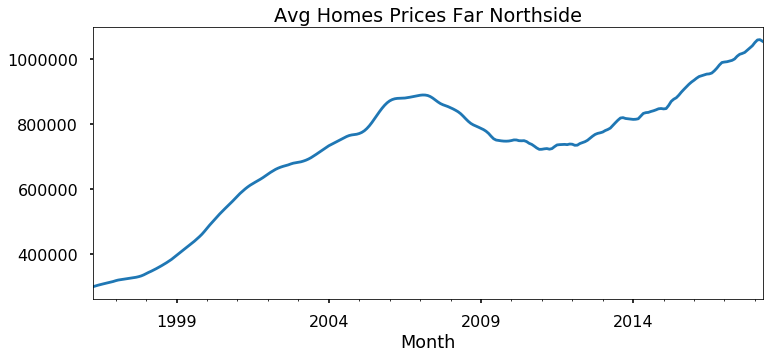

In [87]:
ts = chicago.groupby('RegionName').get_group(far_northside[0]).resample('MS').asfreq()
ts['MeanValue'].plot(figsize=(12,5))
plt.title('Avg Homes Prices Far Northside')

In [46]:
#Function to return zip code(s).  
#Can either enter var name that I've given to group_name or just enter zip code(s)

def get_ts_from_chicago(chicago, group_name):

    ts = chicago.groupby('RegionName').get_group(group_name)
    ts = ts.resample('MS').asfreq()
    ts = ts['MeanValue'].rename(group_name)
    return ts

In [47]:
ts= get_ts_from_chicago(chicago, 60625)

Text(0, 0.5, 'Housing Prices')

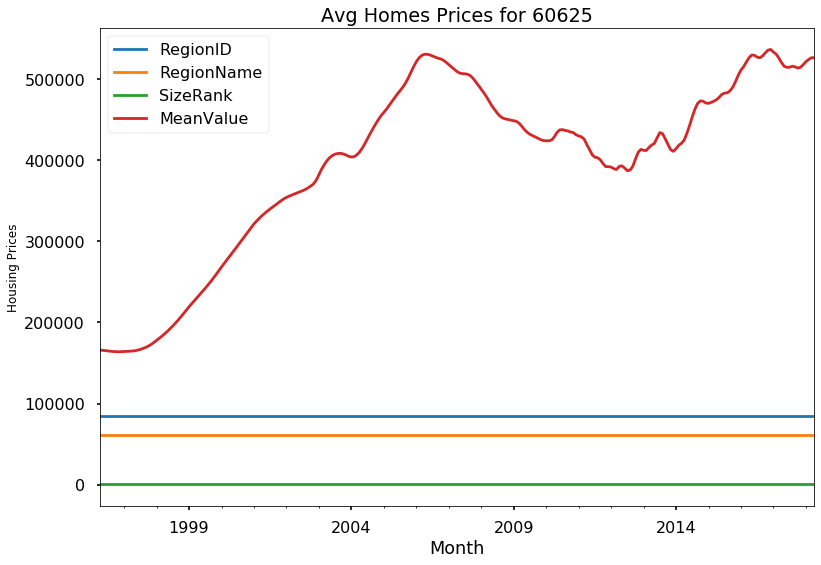

In [117]:
ts.plot()
plt.title('Avg Homes Prices for 60625')
plt.ylabel('Housing Prices', fontsize= 12)

Text(0.5, 1.0, 'Far Northside Housing Price')

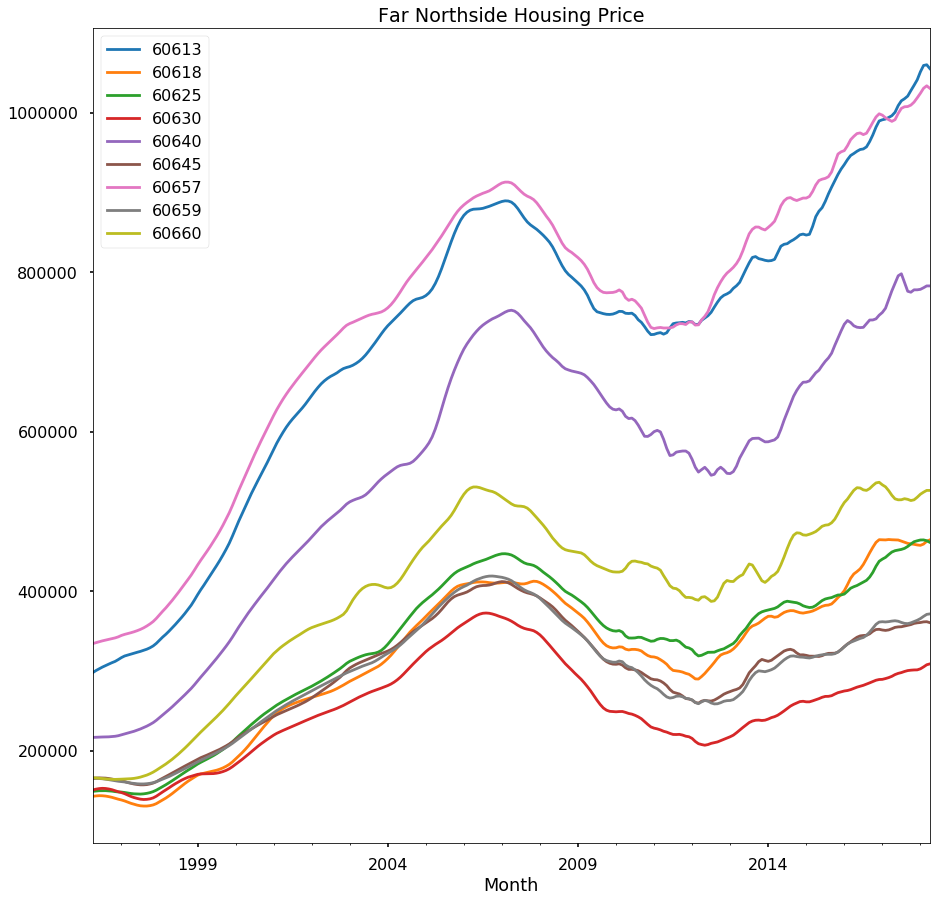

In [110]:
for i in range(len(far_northside)):
    ts = chicago.groupby('RegionName').get_group(far_northside[i])
    ts = ts.resample('MS').asfreq()
    ts['MeanValue'].rename(far_northside[i]).plot(figsize= (15,15))
plt.legend()  
plt.title('Far Northside Housing Price')
#crash = '01-2009'
#plt.vline(crash, label='Housing Index Drops',color='red',ls=':')

### top 5 zipcodes from above:
60657 is Lakeview;
60613 is Lakeview (as well);
60640 is Uptown;
60660 is Edgewater;
60625 is Lincoln Square/Ravenswood;
The rest of the neighborhoods except for Edgebrook (the red line) trends are similar prices

### Graph of home prices for the middle part of the chart

Text(0.5, 1.0, 'Avg Homes Prices for 60660/Edgewater')

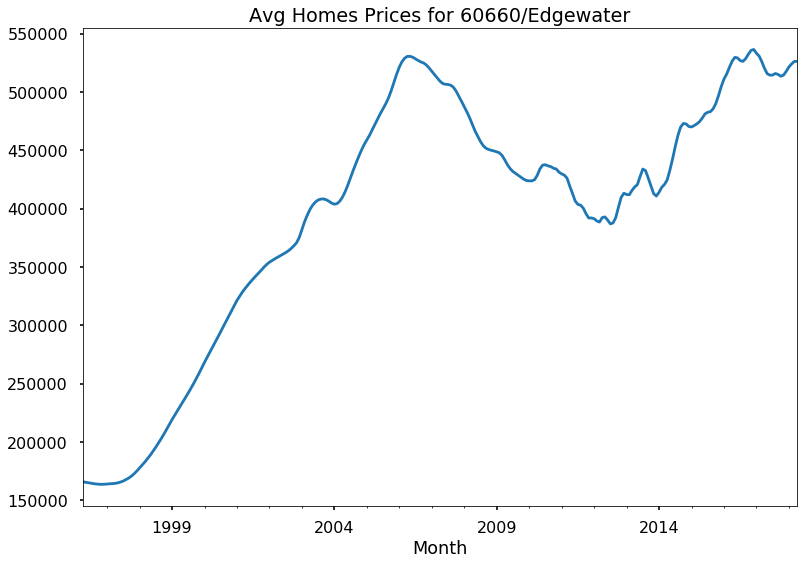

In [94]:
ts_edgewater = get_ts_from_chicago(chicago, 60660)
ts_edgewater.plot()
plt.title('Avg Homes Prices for 60660/Edgewater')

### Edgewater:  160k to 525k

Text(0.5, 1.0, 'Avg Homes Prices for Lakeview')

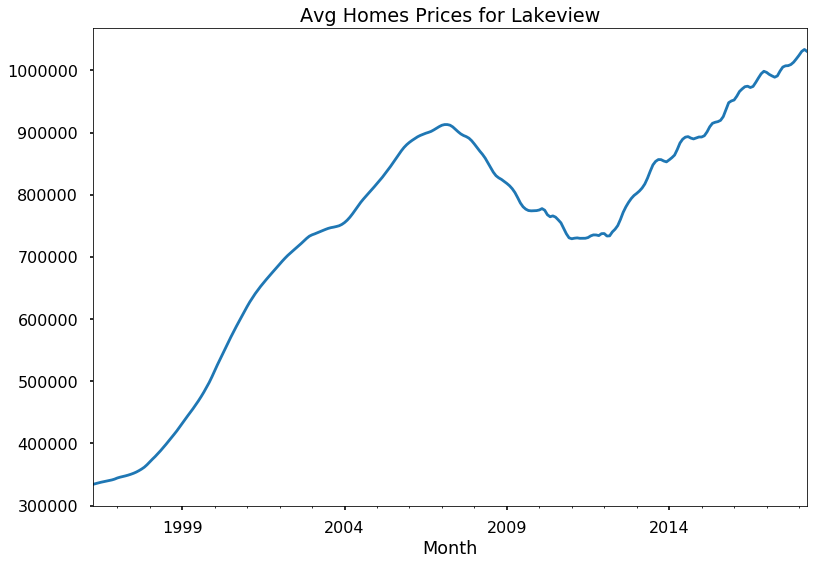

In [96]:
lakeview_ts = get_ts_from_chicago(chicago, 60657)
lakeview_ts.plot()
plt.title('Avg Homes Prices for Lakeview')

## Decomposition

In [97]:
ts

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MeanValue
Month,,,,,,,,
1996-04-01,84615,60613,Chicago,IL,Chicago,Cook,41,297900.0
1996-05-01,84615,60613,Chicago,IL,Chicago,Cook,41,300400.0
1996-06-01,84615,60613,Chicago,IL,Chicago,Cook,41,302600.0
1996-07-01,84615,60613,Chicago,IL,Chicago,Cook,41,304700.0
1996-08-01,84615,60613,Chicago,IL,Chicago,Cook,41,306600.0
...,...,...,...,...,...,...,...,...
2017-12-01,84615,60613,Chicago,IL,Chicago,Cook,41,1041300.0
2018-01-01,84615,60613,Chicago,IL,Chicago,Cook,41,1051300.0
2018-02-01,84615,60613,Chicago,IL,Chicago,Cook,41,1059300.0


In [82]:
from statsmodels.tsa.seasonal import seasonal_decompose
from  statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot,lag_plot

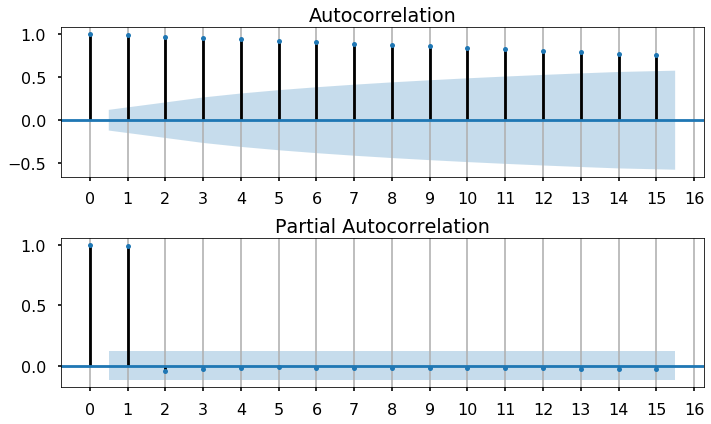

In [98]:
def plot_acf_pacf(ts, figsize=(10,6),lags=15):
    fig,ax = plt.subplots(nrows=2,figsize=figsize)
    plot_acf(ts,ax=ax[0],lags=lags)
    plot_pacf(ts, ax=ax[1],lags=lags) 
    plt.tight_layout()
    
    for a in ax:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    
plot_acf_pacf(ts['MeanValue'])

- AR(p):
    - ACF for AR(p) would be strong until lag of p, then stagnant, then trail off. 
    - PACF for AR(p): Generally no correlation for lag values beyond p.
- MA(q):
    - ACF for MA(q) would show strong correlation up to a lag of q, the immedately delcine to minimal/no correction.
    - PACF would show strong relationship to the lag and tailing off to no correlation afterwards.
   
- Notation is generally ARMA(p,q)
- Example: ARMA(2,1) model equation
     $$Y_t = \mu + \phi_1 Y_{t-1}+\phi_2 Y_{t-2}+ \theta \epsilon_{t-1}+\epsilon_t$$

| Param| AR(p)   |   MA(q)  | ARMA(p,q)|
|------|------|------|------|
|   ACF | Tails off   |  Cuts off after lag q |  Tails off   |
|   PACF | Cuts off after lag p  |   Tails off  |  Tails off  |

### Conclusions for AR(p) and MA(q)

In [100]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [102]:
decomp = seasonal_decompose(ts['MeanValue'])

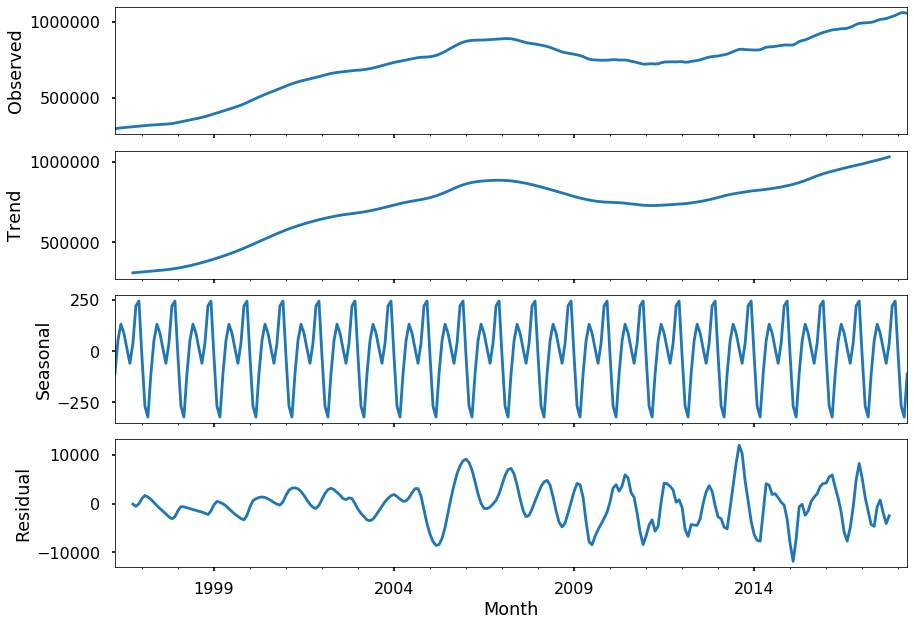

In [106]:
decomp.plot();

#### Conclusion:  The data is non-seasonal because seasonal value is so small in the above chart (compared to size of observed values)

In [119]:
data_diff = ts['MeanValue'].diff().dropna()
data_diff

Month
1996-05-01    -400.0
1996-06-01    -400.0
1996-07-01    -400.0
1996-08-01    -400.0
1996-09-01    -300.0
               ...  
2017-12-01    3200.0
2018-01-01    3800.0
2018-02-01    2600.0
2018-03-01    2200.0
2018-04-01       0.0
Freq: MS, Name: MeanValue, Length: 264, dtype: float64

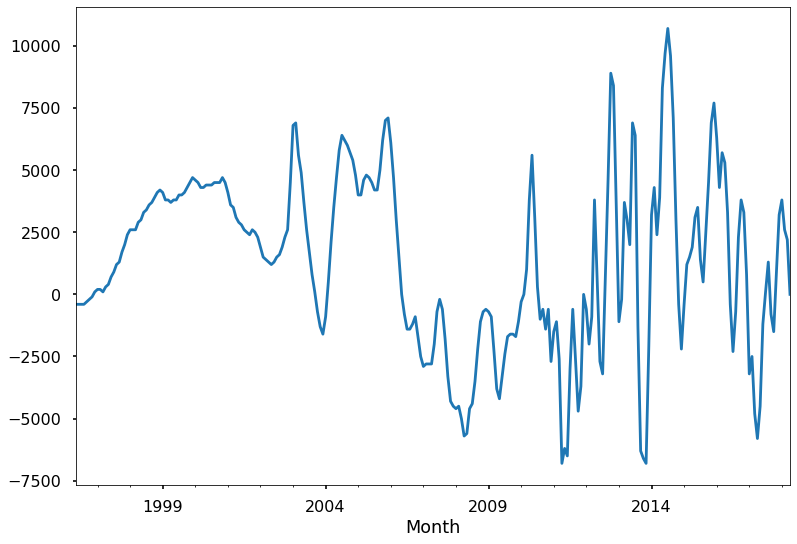

In [120]:
data_diff.plot()

# Step 5: ARIMA Modeling

In [107]:
import itertools

p_range = range(0,3)
q_range = range(0,3)
d_range=range(1,3)


pdq = list(itertools.product(p_range,d_range,q_range))
#PDQM = list(itertools.product(p_range,d_range,q_range,m_range))
#PDQM[:10]

In [108]:
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

# Step 6: Interpreting Results